In [14]:
from common import *
from experiment import *
from data import RawData, DirectRawData, PlottableData
from typing import Union, List
from itertools import chain
import numpy as np

In [15]:
# Define each TCP treatment
TREATMENTS = [
    TCPTreatment(cca='cubic', pep=False),
    TCPTreatment(cca='bbr', pep=False, label='tcp_bbr'),
    TCPTreatment(cca='bbr2', pep=False, label='tcp_bbr2'),
    TCPTreatment(cca='bbr', pep=False, label='tcp_bbr1'),  # When the default bbr module on the current Linux kernel is v1!
    TCPTreatment(cca='cubic', pep=True),
    TCPTreatment(cca='bbr', pep=True, label='pep_bbr'),
    TCPTreatment(cca='bbr2', pep=True, label='pep_bbr2'),
    TCPTreatment(cca='bbr', pep=True, label='pep_bbr1'),  # When the default bbr module on the current Linux kernel is v1!
    QUICTreatment(cca='cubic'),
    QUICTreatment(cca='bbr'),
    QUICTreatment(cca='bbr1'),
]
TCP_CUBIC = TREATMENTS[0]
TCP_BBRV3 = TREATMENTS[1]
TCP_BBRV2 = TREATMENTS[2]
TCP_BBRV1 = TREATMENTS[3]
PEP_CUBIC = TREATMENTS[4]
PEP_BBRV3 = TREATMENTS[5]
PEP_BBRV2 = TREATMENTS[6]
PEP_BBRV1 = TREATMENTS[7]
QUIC_CUBIC = TREATMENTS[8]
QUIC_BBRV3 = TREATMENTS[9]
QUIC_BBRV1 = TREATMENTS[10]

# Splittability heuristic model

In [16]:
class NetworkModel:
    def __init__(self, delay: int, loss: Union[int, float, str], bw: int):
        self.delay = delay
        self.loss = loss
        self.bw = bw

def compose(s1: NetworkModel, s2: NetworkModel) -> NetworkModel:
    delay = s1.delay + s2.delay
    if s1.delay == 1 or s2.delay == 1:
        delay -= 1
    loss = s1.loss + s2.loss
    bw = min(s1.bw, s2.bw)
    return NetworkModel(delay, loss, bw)

In [17]:
def get_data_size(bottleneck_bw):
    return int(10*1000000*bottleneck_bw/8)  # 10x the bottleneck bandwidth

class TreatmentData:
    def __init__(
        self,
        tcp_treatment: Treatment,
        pep_treatment: Treatment,
        data: PlottableData,
        direct_data: PlottableData,
    ):
        self.tcp = tcp_treatment.label()
        self.pep = pep_treatment.label()
        self.data = data
        self.direct_data = direct_data
    
    def goodput(self, s) -> Optional[float]:
        ns = DirectNetworkSetting(delay=s.delay, loss=s.loss, bw=s.bw)
        data_size = get_data_size(s.bw)
        return self.direct_data.data[self.tcp][ns.label()].get(data_size).p(50)
    
    def pred_split_goodput(self, s1: NetworkModel, s2: NetworkModel) -> Optional[float]:
        goodput1 = self.goodput(s1)
        goodput2 = self.goodput(s2)
        if goodput1 is None or goodput2 is None:
            return None
        return min(goodput1, goodput2)
    
    def pred_e2e_goodput(self, s1: NetworkModel, s2: NetworkModel) -> Optional[float]:
        s = compose(s1, s2)
        return self.goodput(s)
    
    def real_split_goodput(self, ns: NetworkSetting) -> Optional[float]:
        data_size = get_data_size(min(ns.get('bw1'), ns.get('bw2')))
        goodput = self.data.data[self.pep][ns.label()].get(data_size)
        return None if goodput is None else goodput.p(50)
    
    def real_e2e_goodput(self, ns: NetworkSetting) -> Optional[float]:
        data_size = get_data_size(min(ns.get('bw1'), ns.get('bw2')))
        goodput = self.data.data[self.tcp][ns.label()].get(data_size)
        return None if goodput is None else goodput.p(50)

# Plotting function

In [18]:
def plot_throughput_accuracy(treatment: TreatmentData, x_labels: List, y_labels: List, network_settings: List[NetworkSetting], title: str, split: bool):
    """
    - treatment: Contains the TCP and PEP treatment for a congestion control algorithm.
    - x_labels: The first axis on which to vary the network settings.
    - y_labels: The second axis on which to vary the network settings.
    - network_settings: A len(y_labels) x len(x_labels) array of network settings generated from the x_labels and y_labels.
    - title: The accuracy metric being assessed, the title of the plot.
    - split: If True, evaluates split accuracy. Otherwise end-to-end accuracy.
    """
    
    # Generate data for the three heatmaps from the network settings
    def init_data():
        return [[0 for _ in range(len(x_labels))] for _ in range(len(y_labels))]
    data_real = init_data()
    data_pred = init_data()
    data_accuracy = init_data()
    for i in range(len(y_labels)):
        for j in range(len(x_labels)):
            ns = network_settings[i][j]
            s1 = NetworkModel(delay=ns.get('delay1'), bw=ns.get('bw1'), loss=ns.get('loss1'))
            s2 = NetworkModel(delay=ns.get('delay2'), bw=ns.get('bw2'), loss=ns.get('loss2'))
            bottleneck_bw = min(ns.get('bw1'), ns.get('bw2'))
            if split:
                real = treatment.real_split_goodput(ns)
                pred = treatment.pred_split_goodput(s1, s2)
            else:
                real = treatment.real_e2e_goodput(ns)
                pred = treatment.pred_e2e_goodput(s1, s2)

            # Set the values if they are not None
            if real is not None:
                data_real[i][j] = real / bottleneck_bw
            if pred is not None:
                data_pred[i][j] = pred / bottleneck_bw
            if real is not None and pred is not None:
                accuracy = (pred - real) / real
                data_accuracy[i][j] = accuracy

    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)
    
    # Function to plot a single heatmap
    def plot_heatmap(ax, data, title):
        im = ax.imshow(data, cmap='viridis', interpolation='nearest', vmin=0, vmax=1)
        ax.set_xticks(np.arange(len(x_labels)))
        ax.set_xticklabels(x_labels, rotation=45, ha='right')
        ax.set_yticks(np.arange(len(y_labels)))
        ax.set_yticklabels(y_labels)
        ax.set_title(title)
        ax.set_xlabel('Delay Split (ms)')
        ax.set_ylabel('Bandwidth Split (Mbit/s)')
        
        # Add numerical labels to each square
        for i in range(len(y_labels)):
            for j in range(len(x_labels)):
                ax.text(j, i, f"{data[i][j]:.2f}", ha='center', va='center',
                        color='white' if data[i][j] < 0.5 else 'black')
        
        return im
    
    # Plot each heatmap
    im1 = plot_heatmap(axes[0], data_real, f'{title} (Real)')
    im2 = plot_heatmap(axes[1], data_pred, f'{title} (Predicted)')
    im3 = plot_heatmap(axes[2], data_accuracy, f'{title} (Accuracy)')
    
    # Add colorbars
    fig.colorbar(im1, ax=axes[0], orientation='vertical', shrink=0.65, label='% Bottleneck Bandwidth Utilization')
    fig.colorbar(im2, ax=axes[1], orientation='vertical', shrink=0.65, label='% Bottleneck Bandwidth Utilization')
    fig.colorbar(im3, ax=axes[2], orientation='vertical', shrink=0.65, label='Accuracy')
    
    # Show the plot
    plt.show()

# Data generation functions

In [19]:
def _tuple_list_to_ordered_set(tuple_list):
    arr = list(chain.from_iterable(tuple_list))
    arr = list(set(arr))
    arr.sort()
    return arr

def gen_direct_data(treatments, bw_splits, delay_splits, loss_splits, timeout=180, execute=False, num_trials=1):
    exp = Experiment(
        num_trials, treatments, [], [],
        network_losses=_tuple_list_to_ordered_set(loss_splits),
        network_delays=_tuple_list_to_ordered_set(delay_splits),
        network_bws=_tuple_list_to_ordered_set(bw_splits),
        timeout=timeout,
        cartesian=False,
    )
    raw_data = DirectRawData(exp, execute=execute)
    plottable_data = PlottableData(raw_data, metric='throughput_mbps')
    return plottable_data
    
def gen_data(treatments, network_settings, timeout=None, execute=False, num_trials=1):
    network_settings = list(chain.from_iterable(network_settings))
    data_sizes = [get_data_size(min(ns.get('bw1'), ns.get('bw2'))) for ns in network_settings]
    exp = Experiment(
        num_trials, treatments, network_settings, data_sizes,
        timeout=timeout,
        cartesian=False,
    )
    raw_data = RawData(exp, execute=execute)
    plottable_data = PlottableData(raw_data, metric='throughput_mbps')
    return plottable_data

In [20]:
def gen_network_settings_without_loss(bw_splits, delay_splits):
    network_settings = []
    for bw1, bw2 in bw_splits:
        nses = []
        for delay1, delay2 in delay_splits:
            ns = NetworkSetting(delay1=delay1, delay2=delay2, bw1=bw1, bw2=bw2, loss1=0, loss2=0)
            nses.append(ns)
        network_settings.append(nses)
    return network_settings

In [44]:
def gen_x_labels_with_loss(bw_splits, delay_splits):
    labels = []
    for bw1, bw2 in bw_splits:
        for delay1, delay2 in delay_splits:
            label = f'{bw1}_{bw2}_{delay1}_{delay2}'
            labels.append(label)
    return labels

def gen_network_settings_with_loss(bw_splits, delay_splits, loss_splits):
    network_settings = []
    for loss1, loss2 in loss_splits:
        nses = []
        for bw1, bw2 in bw_splits:
            for delay1, delay2 in delay_splits:
                ns = NetworkSetting(delay1=delay1, delay2=delay2, bw1=bw1, bw2=bw2, loss1=loss1, loss2=loss2)
                nses.append(ns)
        network_settings.append(nses)
    return network_settings

# Throughput accuracy

In [22]:
TCP_TREATMENT = TCP_BBRV1
PEP_TREATMENT = PEP_BBRV1

## Without loss

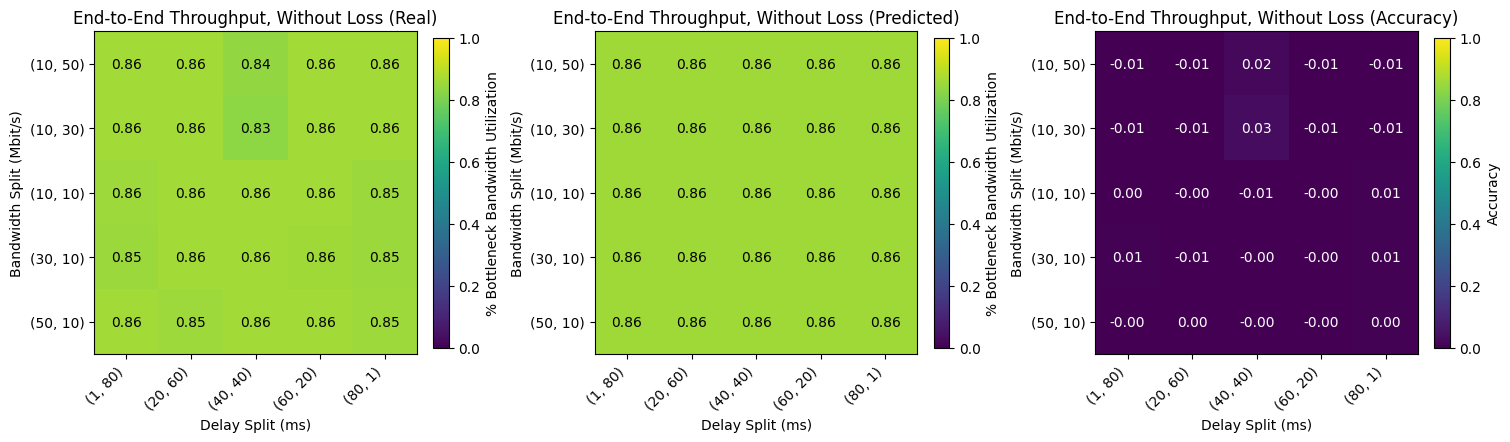

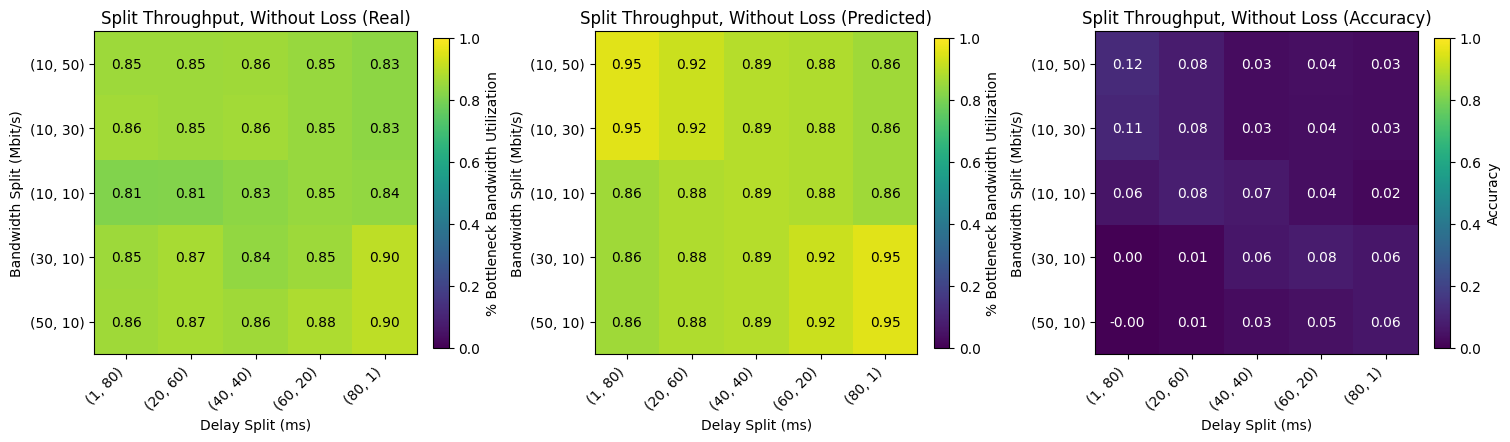

In [29]:
# Define parameters
delay_splits = [(1, 80), (20, 60), (40, 40), (60, 20), (80, 1)]
bw_splits = [(10, 50), (10, 30), (10, 10), (30, 10), (50, 10)]
network_settings = gen_network_settings_without_loss(bw_splits, delay_splits)

# Generate data
data = gen_data([TCP_TREATMENT, PEP_TREATMENT], network_settings, timeout=180, execute=True, num_trials=1)
direct_data = gen_direct_data([TCP_TREATMENT], bw_splits=bw_splits, delay_splits=delay_splits, loss_splits=[(0, 0)], timeout=None, execute=False, num_trials=1)
treatment = TreatmentData(TCP_TREATMENT, PEP_TREATMENT, data=data, direct_data=direct_data)

# Plot heatmaps
plot_throughput_accuracy(treatment, x_labels=delay_splits, y_labels=bw_splits, network_settings=network_settings, title='End-to-End Throughput, Without Loss', split=False)
plot_throughput_accuracy(treatment, x_labels=delay_splits, y_labels=bw_splits, network_settings=network_settings, title='Split Throughput, Without Loss', split=True)

## With loss

MISSING: sudo -E python3 emulation/main.py --timeout 180 --bw1 10 --bw2 50 --delay2 80 --loss1 4 --loss2 0 -t 1 --label tcp_bbr1 tcp -cca bbr -n 12500000
MISSING: sudo -E python3 emulation/main.py --timeout 180 --bw1 10 --bw2 50 --delay1 40 --delay2 40 --loss1 4 --loss2 0 -t 1 --label tcp_bbr1 tcp -cca bbr -n 12500000
MISSING: sudo -E python3 emulation/main.py --timeout 180 --bw1 10 --bw2 50 --delay1 80 --delay2 1 --loss1 4 --loss2 0 -t 1 --label tcp_bbr1 tcp -cca bbr -n 12500000
MISSING: sudo -E python3 emulation/main.py --timeout 180 --bw1 10 --delay2 80 --loss1 4 --loss2 0 -t 1 --label tcp_bbr1 tcp -cca bbr -n 12500000
MISSING: sudo -E python3 emulation/main.py --timeout 180 --bw1 10 --delay1 40 --delay2 40 --loss1 4 --loss2 0 -t 1 --label tcp_bbr1 tcp -cca bbr -n 12500000
MISSING: sudo -E python3 emulation/main.py --timeout 180 --bw1 10 --delay1 80 --delay2 1 --loss1 4 --loss2 0 -t 1 --label tcp_bbr1 tcp -cca bbr -n 12500000
MISSING: sudo -E python3 emulation/main.py --timeout 180 

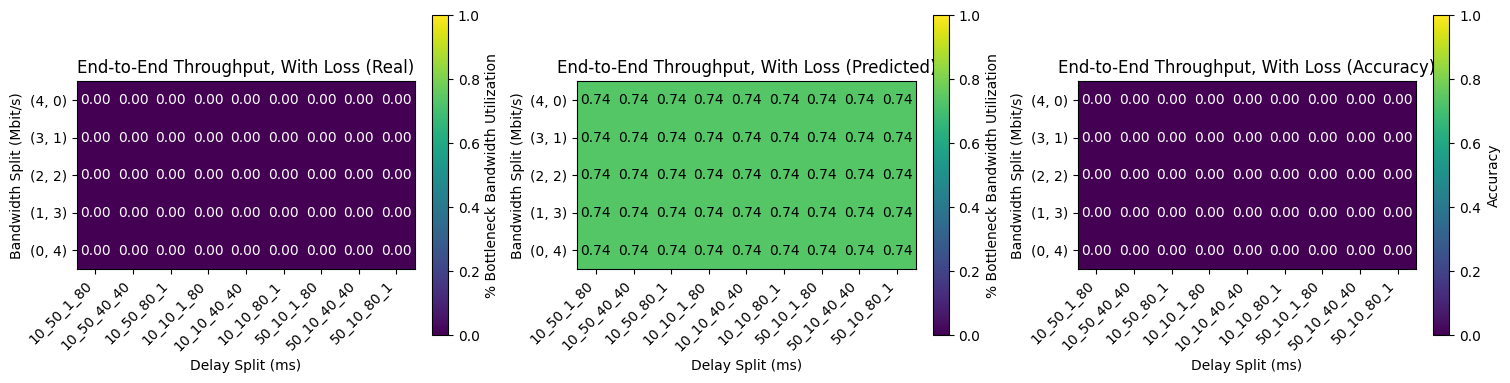

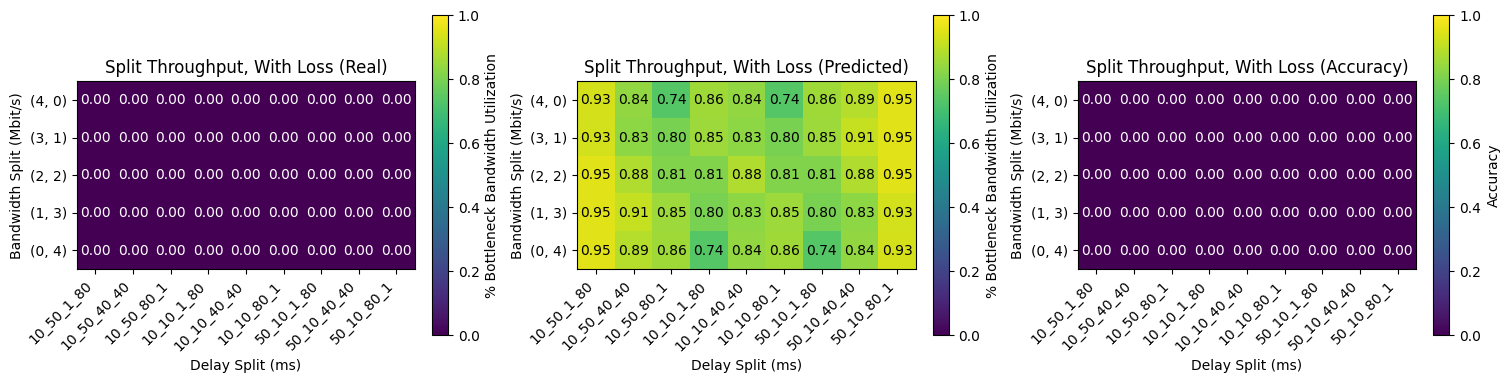

In [45]:
# Define parameters
delay_splits = [(1, 80), (40, 40), (80, 1)]
bw_splits = [(10, 50), (10, 10), (50, 10)]
loss_splits = [(4, 0), (3, 1), (2, 2), (1, 3), (0, 4)]
network_settings = gen_network_settings_with_loss(bw_splits, delay_splits, loss_splits)

# Generate data
data = gen_data([TCP_TREATMENT, PEP_TREATMENT], network_settings, timeout=180, execute=False, num_trials=1)
direct_data = gen_direct_data([TCP_TREATMENT], bw_splits=bw_splits, delay_splits=delay_splits, loss_splits=loss_splits, timeout=None, execute=False, num_trials=1)
treatment = TreatmentData(TCP_TREATMENT, PEP_TREATMENT, data=data, direct_data=direct_data)

# Plot heatmaps
x_labels = gen_x_labels_with_loss(bw_splits, delay_splits)
plot_throughput_accuracy(treatment, x_labels=x_labels, y_labels=loss_splits, network_settings=network_settings, title='End-to-End Throughput, With Loss', split=False)
plot_throughput_accuracy(treatment, x_labels=x_labels, y_labels=loss_splits, network_settings=network_settings, title='Split Throughput, With Loss', split=True)
